In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
df = pd.read_csv('gdrive/My Drive/marathon_results_201701.csv')
df.columns

Index(['Unnamed: 0', 'Bib', 'Name', 'Age', 'Gender', 'City', 'State',
       'Country', 'Citizen', 'Unnamed: 9', '5K', '10K', '15K', '20K', 'Half',
       '25K', '30K', '35K', '40K', 'Pace', 'Proj Time', 'Official Time',
       'Overall', 'Gender.1', 'Division'],
      dtype='object')

In [5]:

# Drop columns not related to race performance.
df = df.drop(columns=['Name', 'Bib', 'Citizen', 'State', 'Country', 'City'])

# Remove hyphens from missing entries
df = df.replace(to_replace='-', value='')

# Convert splits to numeric
splits = ['10K', '25K', '35K', '30K', '5K', 'Half', '20K', '40K' ]
for split in splits:
 df[split] = pd.to_numeric(df[split], errors='coerce').isnull()

# Binarize gender so 1 = female, 0 = male
df['Gender'] = np.where(df['Gender']=='F', 1, 0)

# Drop missing data
df = df.dropna()

In [27]:
# Split data into smaller set for memory reasons
from sklearn.model_selection import train_test_split
df1, df2 = train_test_split(df, test_size=0.90, random_state=42)

# Normalize smaller dataset
#df1_norm = normalize(df1)

Clustering Models

In [7]:

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [8]:
# Specify features - focus on splits every 10k and final time
X = df1.loc[:, ['10K', '20K', '30K', '40K', 'Overall']]
X_norm = normalize(X)

In [9]:
# Run k means model
for k in np.arange(2, 7, 1):
    model = KMeans(n_clusters=k, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.7652869246733524
K: 3, silhouette: 0.7534825493206297
K: 4, silhouette: 0.5958789454543874
K: 5, silhouette: 0.45359927135063544
K: 6, silhouette: 0.38753025215188586


In [16]:

from sklearn.cluster import SpectralClustering

# Run spectral clustering over range of k values
for k in np.arange(2, 4, 1):
    sc = SpectralClustering(n_clusters=k, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

# Memory error if run on higher k

K: 2, silhouette: 0.38753025215188586
K: 3, silhouette: 0.38753025215188586


In [17]:
from sklearn.cluster import AffinityPropagation

# Run and fit model
af = AffinityPropagation().fit(X_norm)

# Get number of clusters
cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
print('K: {}'.format(n_clusters))

K: 3


In [18]:

# PCA for plotting.  Reduce to 2 components
pca = PCA(n_components=2)
pca_X = pca.fit(X_norm).transform(X_norm)

# Get cluster assignments with k=2
model = KMeans(n_clusters=2, random_state=42).fit(X_norm)
labels = model.labels_
df1['cluster'] = labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


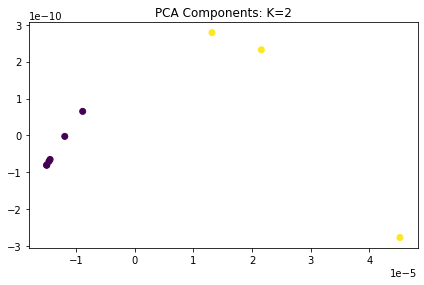

In [19]:
# Plot PCA components and clusters
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=df1['cluster'])
plt.tight_layout()
plt.title('PCA Components: K=2')
plt.show()


In [20]:

# Summary stats, overall time by cluster
df1.groupby(['cluster'])['Overall'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,6.0,25839.5,795.846405,24420.0,25572.75,26230.0,26359.25,26401.0
1,3.0,17251.0,2316.187169,14709.0,16255.50,17802.0,18522.00,19242.0


In [22]:

# Summary stats, gender distribution by cluster
df1.groupby(['cluster'])['Gender'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,6.0,0.333333,0.516398,0.0,0.0,0.0,0.75,1.0
1,3.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0


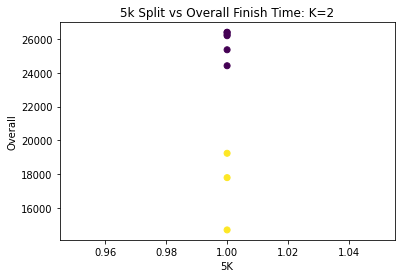

In [25]:

# Plot 5k split vs overall finish
plt.scatter(df1['5K'], df1['Overall'], c=df1['cluster'])
plt.xlabel('5K')
plt.ylabel('Overall')
plt.title('5k Split vs Overall Finish Time: K=2')
plt.show()

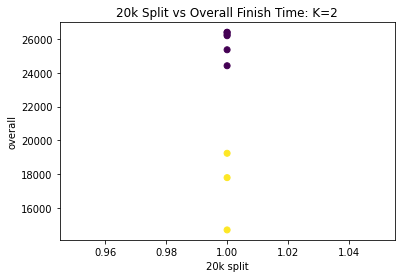

In [26]:
# Plot 20k split vs overall finish time
plt.scatter(df1['20K'], df1['Overall'], c=df1['cluster'])
plt.xlabel('20k split')
plt.ylabel('overall')
plt.title('20k Split vs Overall Finish Time: K=2')
plt.show()